In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Generation

In [2]:
def generate_isotropic_gmm_data(d, N, scale_factor=1.0):
    M = int(np.log2(d))
    R = 2 * np.abs(np.log2(d))
    means = np.random.uniform(-R, R, size=(M, d))
    covariances = np.eye(d) * scale_factor
    weights = np.ones(M) / M
    
    # generate our data points
    data = []
    for _ in range(N):
        # choose the mixture component
        mixture_idx = np.random.choice(M, p=weights)
        mean = means[mixture_idx]
        data.append(np.random.multivariate_normal(mean, covariances)) #d et pas 1/d? 
    
    return np.array(data), means

d = 8
n_comp = int(np.log2(d))
N = 2**d
scale_factor = 1.0
synthetic_data, true_means = generate_isotropic_gmm_data(d, N, scale_factor)
print("Synthetic dataset shape:", synthetic_data.shape)

Synthetic dataset shape: (256, 8)


In [3]:
R = 2 * np.abs(np.log2(d))
means = np.random.uniform(-R, R, size=(3, 8))

In [4]:
means.shape

(3, 8)

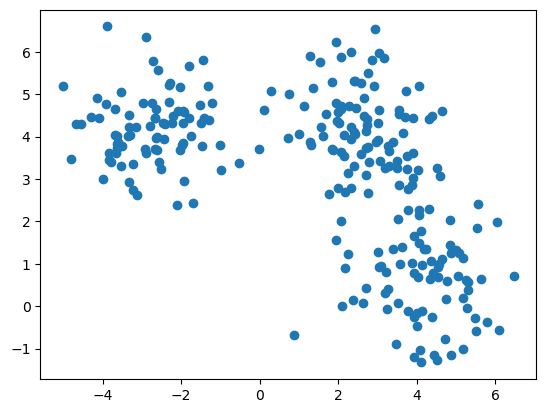

In [5]:
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1])

In [6]:
synthetic_data[:,0]

array([ 4.85894115,  5.63143161,  2.73435175,  4.08531828, -3.62722975,
        4.2516135 ,  6.10392122,  1.35856624,  4.76808034, -3.52297045,
        2.75880773, -2.23454188,  2.94780145, -2.51159751, -4.15371122,
        2.70456664,  2.26261964,  3.23449436, -3.69792604, -3.35008099,
        2.33785586, -1.32493035,  2.07680832,  3.55397005,  3.91727614,
        3.53125624,  2.14167163,  5.26764046, -1.42899501,  3.01670714,
        4.00708526, -2.11608187,  2.08322536,  4.73323112,  1.9415311 ,
       -2.75506293,  5.00820955, -3.84387757,  4.01065566,  4.59841954,
        2.90202841,  2.16604608,  0.71336187,  1.96092901,  2.43437147,
       -2.675792  ,  2.63934234,  0.73734865,  5.50045074, -2.65457382,
       -4.55956032, -1.94106676,  2.09187771, -3.67035789, -2.311441  ,
        4.05562135,  4.43961952, -2.09441075,  2.9671126 , -3.15970463,
        3.29658933,  3.79234431, -1.28118331,  4.50836411,  2.17821477,
        2.70671185, -3.89557722,  3.23050457,  3.40044071,  3.20

## EM algorithm

### Expectation-Maximization Algorithm for Gaussian Mixture Models

The Expectation-Maximization (EM) algorithm is an iterative method for finding the maximum likelihood estimates of parameters in statistical models, particularly useful for unsupervised learning tasks like clustering. In the context of Gaussian Mixture Models (GMM), the EM algorithm iteratively optimizes the parameters of multiple Gaussian distributions to fit the observed data.

#### Algorithm Steps:

1. **Initialization**: Start by initializing the parameters of the Gaussian components: means, covariances, and mixing coefficients.

2. **Expectation Step (E-step)**:
   - Compute the responsibilities (likelihoods) of each data point belonging to each Gaussian component.
   - Responsibilities are computed based on the current parameters using the multivariate normal distribution.

3. **Maximization Step (M-step)**:
   - Update the parameters (means, covariances, and mixing coefficients) using the responsibilities computed in the E-step.
   - Expressions for updating parameters:
     - **Means**: Weighted average of data points using responsibilities.
     - **Covariances**: Weighted covariance matrix of data points using responsibilities.
     - **Mixing Coefficients**: Mean of responsibilities.

4. **Compute Log-Likelihood**:
   - Compute the log-likelihood of the data given the current parameters and responsibilities.
   - Log-likelihood serves as a measure of how well the model fits the data.

5. **Convergence Check**:
   - Iterate between the E-step and M-step until convergence, typically based on a convergence criterion such as changes in log-likelihood or parameter values.

#### Expressions for Updating Parameters:

- **Means**: 

$$ \mu_k = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) \cdot x_i}{\sum_{i=1}^{N} \gamma(z_{ik})} $$

- **Covariances**:
  $$ \Sigma_k = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) \cdot (x_i - \mu_k)(x_i - \mu_k)^T}{\sum_{i=1}^{N} \gamma(z_{ik})} $$

- **Mixing Coefficients**:
  $$ \pi_k = \frac{\sum_{i=1}^{N} \gamma(z_{ik})}{N} $$

Here, $ \gamma(z_{ik}) $ represents the responsibility of data point $ x_i $ belonging to Gaussian component $ k $.



In [7]:
import numpy as np
from scipy.stats import multivariate_normal

def initialize_parameters(data, num_components):
    num_data_points, num_features = data.shape
    # Initialize means randomly
    means = np.random.rand(num_components, num_features)
    # Initialize covariances as identity matrices
    covariances = [np.eye(num_features)] * num_components
    # Initialize mixing coefficients uniformly
    mixing_coefficients = np.ones(num_components) / num_components
    return means, covariances, mixing_coefficients

def expectation_step(data, means, covariances, mixing_coefficients):
    num_data_points = len(data)
    num_components = len(means)
    responsibilities = np.zeros((num_data_points, num_components))

    for i in range(num_data_points):
        for j in range(num_components):
            responsibilities[i, j] = mixing_coefficients[j] * multivariate_normal.pdf(data[i], means[j], covariances[j])

    # Normalize the responsibilities
    responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]

    return responsibilities

def maximization_step(data, responsibilities):
    num_data_points, num_components = responsibilities.shape
    num_features = data.shape[1]
    means = np.zeros((num_components, num_features))
    covariances = [np.zeros((num_features, num_features))] * num_components
    mixing_coefficients = np.zeros(num_components)

    for j in range(num_components):
        # Update means
        means[j] = np.sum(responsibilities[:, j][:, np.newaxis] * data, axis=0) / np.sum(responsibilities[:, j])

        # Update covariances
        diff = data - means[j]
        covariances[j] = np.dot((responsibilities[:, j][:, np.newaxis] * diff).T, diff) / np.sum(responsibilities[:, j])

        # Update mixing coefficients
        mixing_coefficients[j] = np.mean(responsibilities[:, j])

    return means, covariances, mixing_coefficients

def em_algorithm(data, num_components, max_iterations=100, tolerance=1e-60):
    means, covariances, mixing_coefficients = initialize_parameters(data, num_components)
    prev_log_likelihood = float('-inf')

    for iteration in range(max_iterations):
        responsibilities = expectation_step(data, means, covariances, mixing_coefficients)
        means, covariances, mixing_coefficients = maximization_step(data, responsibilities)

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
        print(f"Likelihood difference: {log_likelihood - prev_log_likelihood}")

        # Check for convergence
        if abs(log_likelihood - prev_log_likelihood) < tolerance:
            break

        prev_log_likelihood = log_likelihood

    return means, covariances, mixing_coefficients

num_components = n_comp # Number of Gaussian components
means, covariances, mixing_coefficients = em_algorithm(synthetic_data, num_components)
print("Means:", means)
print("Covariances:", covariances)
print("Mixing Coefficients:", mixing_coefficients)

Likelihood difference: inf
Likelihood difference: 3.1086244689504383e-15
Likelihood difference: -3.3306690738754676e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: 7.771561172376095e-16
Likelihood difference: -2.220446049250312e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 5.551115123125783e-16
Likeli

In [8]:
print(means)
print(true_means)

[[ 2.82256216  3.72702775  1.56627636  1.50306266  5.48765872 -5.23341079
  -0.59475157 -1.02634069]
 [ 2.57583397  4.22895525  1.07145912  2.23256159  5.82193776 -4.86979733
  -0.16750762 -1.74798222]
 [ 0.5595525   2.45997631  4.19127277  3.27064658 -3.16272554  0.83913899
   0.85298938 -2.96854934]]
[[ 2.47342384  4.22573492  1.32463424  1.99032367  5.8114155  -4.82798366
  -0.14849662 -1.63759682]
 [ 4.11152271  0.60525725  2.437919    0.9205192  -2.22249932  4.83888045
  -0.60607309 -5.98031584]
 [-2.86423722  4.25689187  5.71374065  5.41505262 -3.99175402 -2.75489079
   2.07496891 -0.02623007]]


## MALA

In [9]:
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import torch
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm

In [100]:
def accept_filter(log_ratio, x, x_init):

    log_u = torch.log(torch.rand_like(log_ratio))
    acc = log_u < log_ratio
    x[~acc] = x_init[~acc]

    return x, acc


def get_grad_U(U):
    """
    Function to get grad of input function via autodiff
   
    U: function with single tensor input
    """
    @torch.enable_grad()
    def grad_U(x):
        x = x.clone().detach().requires_grad_()
        return torch.autograd.grad(U(x).sum(), x)[0]
    return grad_U

def run_mala(target_U, grad_U, x_init, n_steps=1000, dt=0.005, beta_eff=1, with_tqdm=False,cvg=False,criterions=[0,0]):
    """
    target_U: function - target potential we will run the Langevin on (negative log prob)
    grad_U: function - grad of target_U
    x (tensor): init points for the chains to update (batch_dim, dim)
    dt : time step
    beta_eff: additional control to change temperature of target U
    cvg: bool - runs the code until convergence criterions are met. if false, uruns the code for n_steps 
    criterions: list - the two tolerances for the convergence criterions. The first one uses the empirical mean of the log_likelihood of the generated sample, the second one uses the empirical mean of the sample.
    """
    def step(target_U, grad_U, x_init, n_steps, dt, beta_eff):
        """
        One step of the mala algorithm. This function was created to avoid repeating the code twice.
        """
        
        x = x_init.clone()
        x = x_init - dt * grad_U(x_init)
        if dt > 0:
            x += dt * np.sqrt(2 / (dt * beta_eff)) * torch.randn_like(x_init)

        log_ratio = -target_U(x)
        log_ratio -= ((x_init - x + dt * grad_U(x)) ** 2 / (4 * dt)).sum()
        log_ratio += target_U(x_init)  # Reshape to match the shape of log_ratio
        log_ratio += ((x - x_init + dt * grad_U(x_init)) ** 2 / (4 * dt)).sum()
        log_ratio = beta_eff * log_ratio

        x, acc = accept_filter(log_ratio, x, x_init)

        accs.append(acc)
        xs.append(x.clone())
        x_init = x.clone().detach()
        
        return xs,x_init,acc
    
    xs = []
    accs = []

    range_ = tqdm.tqdm(range(n_steps)) if with_tqdm else range(n_steps)
    if not cvg:
        
        for t in range_:
            xs,x_init,acc = step(target_U, grad_U, x_init, n_steps, dt, beta_eff)
            
    
    else:
        t=1
        crit_1 = np.inf
        crit_2 = np.inf
        sum_logprob_mala = 0
        
        
        while crit_1>1e-6  or crit_2>1e-3:
            if not xs:
                t+=1
                xs,x_init,acc = step(target_U, grad_U, x_init, n_steps, dt, beta_eff)
            else:
                xs,x_init,acc = step(target_U, grad_U, x_init, n_steps, dt, beta_eff)
                x_temp = torch.stack(xs)
                sum_logprob_mala += U(xs[-1])
                crit_1 = abs(sum_logprob_mala/t - criterions[0])
                
                empirical_mean=(torch.sum(x_temp,dim=0)/t).T
                crit_2 = np.linalg.norm(empirical_mean - criterions[1])
                t+=1
                if t%100:
                    print(f"iteration n°{t}")
        print(f"end of the loop. Number of iterations: {t}")
                
    return torch.stack(xs), torch.stack(accs)

In [69]:
# function that returns a function that computes the negative log probability of a given dataset
def get_log_prob(data):
    N = data.shape[0]
    d = data.shape[1]
    R = 2 * np.abs(np.log2(d))

    def log_mu_prior(mu):
        M = mu.shape[1]
        return -(torch.norm(mu) - np.sqrt(M) * R) ** 2 * int(torch.norm(mu) > np.sqrt(M) * R)

    def log_prob(mu):
        # Compute squared distances between each data point and each mean
        squared_distances = torch.sum((data.unsqueeze(1) - mu.t().unsqueeze(0)) ** 2, dim=2)

        # Compute the log probabilities for each data point and each mixture component
        log_probs = -0.5 * squared_distances / (1000 * data.shape[1])

        # Sum over mixture components and take the log-sum-exp to compute the log probability
        max_log_probs, _ = torch.max(log_probs, dim=1, keepdim=True)
        log_prob_ = torch.log(torch.sum(torch.exp(log_probs - max_log_probs), dim=1)) + max_log_probs.squeeze()

        return -torch.sum(log_prob_)

    return log_prob

In [70]:
M = int(np.log2(d))
U = get_log_prob(torch.Tensor(synthetic_data))
grad_U = get_grad_U(U)

x_init = torch.Tensor(synthetic_data[:M, :].T)

In [72]:
n_steps=50_000 #arbitrarly large number
mean_estimates=[]
logprob_estimates=[]
for i in range(0,2):
    objective_estimation, objective_accs = run_mala(U, grad_U, x_init, n_steps, dt=0.005)
    empirical_mean=(torch.sum(objective_estimation,dim=0)/n_steps).T
    log_prob_mala=0
    
    for j in range(n_steps):
        log_prob_mala += U(objective_estimation[j])/n_steps
    
        mean_estimates.append(empirical_mean)
        logprob_estimates.append(log_prob_mala)

In [81]:
log_prob_mala=0
for j in range(n_steps):
        log_prob_mala += U(objective_estimation[j])/n_steps
    
        mean_estimates.append(empirical_mean)
        logprob_estimates.append(log_prob_mala)

In [82]:
crit1 = sum(logprob_estimates)/len(logprob_estimates)
crit2 = sum(mean_estimates)/len(mean_estimates)

In [ ]:
xs, accs,c = run_mala(U, grad_U, x_init, dt=0.005,cvg=True,criterions=[crit1,crit2])